In [1]:
import numpy as np
import pandas as pd
import glob

# import packages
import glob
from pathlib import Path
import os
import numpy as np
from datetime import datetime
from datetime import timedelta
import pandas as pd
import calendar
import geopandas as gpd
import cartopy
import matplotlib.pyplot as plt
import math
from pathos.threading import ThreadPool as Pool
from scipy.optimize import least_squares
import sklearn
from sklearn.linear_model import LinearRegression
from scipy.stats import gaussian_kde
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

from f_sr_calculation import *

work_dir=Path("/scratch/fransjevanoors/global_sr")
#work_dir=Path('/tudelft.net/staff-umbrella/LSM root zone/global_sr')
data_dir=Path(f'{work_dir}/data')
out_dir = Path(f"{work_dir}/output")

In [18]:
def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    adjust_yaxis(ax2,(y1-y2)/2,v2)
    adjust_yaxis(ax1,(y2-y1)/2,v1)

def adjust_yaxis(ax,ydif,v):
    """shift axis ax by ydiff, maintaining point v at the same location"""
    inv = ax.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, ydif))
    miny, maxy = ax.get_ylim()
    miny, maxy = miny - v, maxy - v
    if -miny>maxy or (-miny==maxy and dy > 0):
        nminy = miny
        nmaxy = miny*(maxy+dy)/(miny+dy)
    else:
        nmaxy = maxy
        nminy = maxy*(miny+dy)/(maxy+dy)
    ax.set_ylim(nminy+v, nmaxy+v)

In [5]:
pep_dir = f'{work_dir}/output/forcing_timeseries/processed/daily'
q_dir = f'{work_dir}/output/q_timeseries_selected'
out_dir = f'{work_dir}/output/sr_calculation/sd_catchments'
snow_id_list = np.genfromtxt(f'{work_dir}/output/snow/catch_id_list_snow_t_and_p.txt',dtype='str')
snow_dir = f'{work_dir}/output/snow/timeseries_gswp'
irri_ids = np.loadtxt(f'{work_dir}/output/irrigation/catchment_irri_area_5percent.txt',dtype=str)

catch_list = np.genfromtxt(f'{work_dir}/output/gsim_aus_catch_id_list_lo_sel_area_wb.txt',dtype='str')[:]

# check which catchments are missing
el_id_list=[]
for filepath in glob.iglob(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.8ia/sd/*.csv'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-11] # remove .year extension
    el_id_list.append(f)
dif = list(set(catch_list) - set(el_id_list))
print(len(dif))
catch_list = dif

2822


In [6]:
catch_id = 'id_0000009'

In [7]:
"""
run calculation of storage deficits (1)

catch_id:    str, catchment id
pep_dir:     str, dir, directory of P and Ep timeseries
q_dir:       str, dir, directory of Q timeseries
out_dir:     str, dir, output directory

returns: out:sd timeseries, stores out dataframe (Sd calculation) as csv
"""

if catch_id in snow_id_list:
    s = 1 # snow is yes
    f_pep = glob.glob(f'{snow_dir}/{catch_id}*.csv')

else:
    s = 0 # snow is no
    # get P Ep and Q files for catch id
    f_pep = glob.glob(f'{pep_dir}/{catch_id}*.csv')

cc = pd.read_csv(f'{work_dir}/output/catchment_characteristics/gswp-p_gleam-ep_gswp-t/{catch_id}.csv',index_col=0)
ir_area = cc.ir_mean.values

# read q df
f_q = glob.glob(f'{q_dir}/{catch_id}*.csv')

# read files as dataframes
q_ts = pd.read_csv(f_q[0],index_col=0)
q_ts.index = pd.to_datetime(q_ts.index)
pep_ts = pd.read_csv(f_pep[0],index_col=0)
pep_ts.index = pd.to_datetime(pep_ts.index)

if (s==1): #snow
    # convert to monthly dataframes
    df_monthly = pd.DataFrame(index=pd.date_range(pep_ts.index[0],pep_ts.index[-1],freq='M'), columns=['p','ep','ps','pm','pl'])
    df_monthly[['p','ep','ps','pm','pl']] = pep_ts[['p','ep','ps','pm','pl']].groupby(pd.Grouper(freq="M")).sum()

    # calculate start hydroyear -> month after on average the wettest month
    df_monthly_mean = df_monthly.groupby([df_monthly.index.month]).mean()
    df_monthly_mean['liq'] = df_monthly_mean['pm'] + df_monthly_mean['pl']
    wettest_month = (df_monthly_mean['liq']-df_monthly_mean['ep']).idxmax()
    hydro_year_start_month = wettest_month+1
    if hydro_year_start_month==13:
        hydro_year_start_month=1

else: # no snow
    # convert to monthly dataframes
    df_monthly = pd.DataFrame(index=pd.date_range(pep_ts.index[0],pep_ts.index[-1],freq='M'), columns=['p','ep'])
    df_monthly[['p','ep']] = pep_ts[['p','ep']].groupby(pd.Grouper(freq="M")).sum()

    # calculate start hydroyear -> month after on average the wettest month
    df_monthly_mean = df_monthly.groupby([df_monthly.index.month]).mean()
    wettest_month = (df_monthly_mean['p']-df_monthly_mean['ep']).idxmax()
    hydro_year_start_month = wettest_month+1
    if hydro_year_start_month==13:
        hydro_year_start_month=1

# find the start and end date for the sr calculation based on P, Ep, Q timeseries and hydroyear
p_ep_start_year = pep_ts.index.year[0]
q_start_year = int(q_ts.index[0].year)
p_ep_end_year = pep_ts.index.year[-1]
q_end_year = int(q_ts.index[-1].year)

# test if timeseries have overlap -> if not don't continue the sd calculation
if q_start_year>p_ep_end_year:
    a=1
elif p_ep_start_year>q_end_year:
    a=1
else:
    a=0
    start_year = max(q_start_year,p_ep_start_year)
    end_year = min(q_end_year,p_ep_end_year)
    start_date = datetime(start_year,hydro_year_start_month,1)
    end_date = datetime(end_year,hydro_year_start_month,1)
    end_date = end_date - timedelta(days=1)

    #calculate mean Q for startdate enddate timeseries
    q_mean = q_ts.loc[start_date:end_date,'Q'].mean()

    if (s==1): # snow
        # prepare input dataframe for sd calculation
        sd_input = pd.DataFrame(index=pd.date_range(start_date,end_date,freq='d'), columns=['p','ep','ps','pm','pl','date_start','date_end'])
        sd_input[['p','ep','ps','pm','pl']] = pep_ts[['p','ep','ps','pm','pl']]
        sd_input[['date_start','date_end']] = start_date, end_date
        si_0 = 0 #initial interception storage
        si_max = 2.5 #maximum interception storage

    else: # no snow
        # prepare input dataframe for sd calculation
        sd_input = pd.DataFrame(index=pd.date_range(start_date,end_date,freq='d'), columns=['p','ep','date_start','date_end'])
        sd_input[['p','ep']] = pep_ts[['p','ep']]
        sd_input[['date_start','date_end']] = start_date, end_date
        si_0 = 0 #initial interception storage
        si_max = 2.5 #maximum interception storage

    # run sd calculation
    b = sd_initial(sd_input, si_0, si_max, q_mean,s)[0] #b==0: closing wb, b==1: non-closing wb > no sd calculation
    if b==0:      
        # save output dataframe from sd calculation
        out = sd_initial(sd_input, si_0, si_max, q_mean,s)[1]

#         # if catch_id in irri_id_list:
#         # if ir_area>0.01:
#         if ir_area>0:
#             irri = irrigation_sd(out,catch_id,work_dir)
#             out = irri[0] 
#             se_out = irri[1]
#             f = irri[2]
#             se_out.to_csv(f'{out_dir}/irri/f0.8ia/se/{catch_id}_f0.8ia.csv')
#             # se_out.to_csv(f'{out_dir}/irri/fiwu2/se/{catch_id}_fiwu2.csv')
#             # se_out.to_csv(f'{out_dir}/irri/se/{catch_id}_f{f}ia.csv')

#             out.to_csv(f'{out_dir}/irri/f0.8ia/sd/{catch_id}_f0.8ia.csv')
#             # out.to_csv(f'{out_dir}/{catch_id}.csv')
#             # out.to_csv(f'{out_dir}/irri/fiwu2/sd/{catch_id}_fiwu2.csv')
#             # out.to_csv(f'{out_dir}/irri/sd/{catch_id}_f{f}ia.csv')
#         else: 
#             # out.to_csv(f'{out_dir}/irri/fiwu2/sd/{catch_id}_fiwu2.csv')
#             out.to_csv(f'{out_dir}/irri/f0.8ia/sd/{catch_id}_f0.8ia.csv')


/home/fransjevanoors/.conda/envs/sr_env/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/fransjevanoors/.conda/envs/sr_env/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [57]:
out

,p,ep,date_start,date_end,Si_1,Pe,Si_2,Ei,Si_3,Et,Sd,se,p_irri,sd2,se2,pi
1981-04-01,18.166052,2.923416,1981-04-01,2009-03-31,18.166052,15.666052,2.5,2.5,0.0,1.397241,0.000000,0.000000,15.666052,0.000000,14.268811,0.0
1981-04-02,3.025998,2.843305,1981-04-01,2009-03-31,3.025998,0.525998,2.5,2.5,0.0,1.358952,-0.832954,0.000000,0.525998,-0.832954,0.000000,0.0
1981-04-03,3.149284,2.669151,1981-04-01,2009-03-31,3.149284,0.649284,2.5,2.5,0.0,1.275715,-1.459385,0.000000,0.649284,-1.459385,0.000000,0.0
1981-04-04,9.056500,2.997876,1981-04-01,2009-03-31,9.056500,6.556500,2.5,2.5,0.0,1.432829,0.000000,5.123671,6.556500,0.000000,5.123671,0.0
1981-04-05,27.943600,3.353763,1981-04-01,2009-03-31,27.943600,25.443600,2.5,2.5,0.0,1.602924,0.000000,23.840676,25.443600,0.000000,23.840676,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-03-27,7.036840,3.899651,1981-04-01,2009-03-31,7.036840,4.536840,2.5,2.5,0.0,1.863830,0.000000,2.673009,4.536840,0.000000,2.673009,0.0
2009-03-28,4.433677,3.870490,1981-04-01,2009-03-31,4.433677,1.933677,2.5,2.5,0.0,1.849893,0.000000,0.083784,1.933677,0.000000,0.083784,0.0
2009-03-29,9.714232,3.798144,1981-04-01,2009-03-31,9.714232,7.214232,2.5,2.5,0.0,1.815315,0.000000,5.398916,7.214232,0.000000,5.398916,0.0
2009-03-30,10.625620,3.459156,1981-04-01,2009-03-31,10.625620,8.125620,2.5,2.5,0.0,1.653297,0.000000,6.472323,8.125620,0.000000,6.472323,0.0


Text(0, 0.5, 'Sd (mm)')

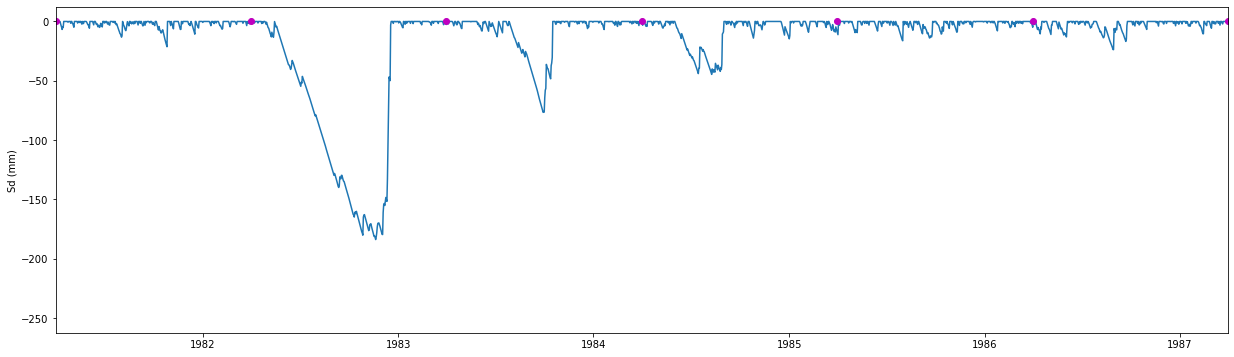

In [77]:
a = []
for i in range(len(out.index.year.unique())):
    a.append(datetime(year=out.index.year.unique()[i],month=out.index.month[0],day=out.index.day[0]))

fig = plt.figure(figsize=(21,6))
ax = fig.add_subplot(111)
ax.plot(out.index,out.Sd)
ax.plot(a,np.zeros(len(a)),'mo')
ax.set_xlim(out.index[0],out.index[6*365])
ax.set_ylabel('Sd (mm)')

In [138]:
s = out
df = out
split_dates = []
start_date = df.index[0]
split_dates.append(start_date)
se_l = []
se_used = []
ldd_l = []
lde_l = []
days_l = []
f_ar = []
s2 = s #make new dataframe, copy of s which is output of initial sd calculation
s2['p_irri']=s.Pe #set initially p irri to Pe
s2['sd2']=s.Sd
s2['se2']=s.se
iwu = pd.read_csv(f'{work_dir}/output/irrigation/processed2/monthly_mean/{catch_id}.csv',index_col=0)
iwu_mean = iwu.mean().values[0]*365
# cc = pd.read_csv(f'{work_dir}/output/catchment_characteristics/gswp-p_gleam-ep_gswp-t/{catch_id}.csv',index_col=0)
# ir_area = cc.ir_mean.values
ir2 = pd.read_csv(f'{work_dir}/data/irrigated_area/output/combined_ia.csv',index_col=0) 
ir_area = ir2.loc[catch_id].hi

# years=len(np.unique(s.index.year)) #count years
years = 5
for i in range(years):
    ss = s2.iloc[i*365:(i*365)+365] #select 1 year
    min_date = ss[ss.Sd==ss.Sd.min()].index.values[0] #select date where Sd minimizes
    split_dates.append(min_date) #append first date to split_dates list
    sp = s2.loc[split_dates[i]:split_dates[i+1]]
    se_sum = sp.se2.sum() #sum se from start date to date with min Sd
    se_l.append(se_sum)

    # find last date of Se>0 BEFORE min date = first day deficit
    sss = ss.loc[:min_date]
    if (len(sss.se[sss.se>0])>0):
        lde = sss.se[sss.se>0].index[-1]
    else:
        lde = sss.index[0]   

    # find first day of deficit Sd==0 AFTER min date = last day deficit
    sss = ss.loc[min_date:]
    if (len(sss.Sd[sss.Sd==0])>0):
        ldd = sss[sss.Sd==0].index[0]
    else:
        ldd = sss.Sd.index[-1]

    ldd_l.append(ldd)
    lde_l.append(lde)
    dd = ss.loc[lde+timedelta(days=1):ldd] # select from start of deficit until end of deficit period
    days = len(dd) # length of deficit period = length of irrigation period
    days_l.append(days)

    # f = 0.17 #
    # f2 = f
    # f based on fixed factor and irrigated area fraction
    f = 0.2
    f2 = min(f*ir_area, 1) 

    # f based on IWU directly
    # if (se_sum>0):
    #     f = iwu_mean/se_sum
    # else: 
    #     f=0
    # if (f>1):
    #     f=1
    # f2=f

    #use this with fia
    # f_ar.append(f2[0]) 
    # if (days>0):
    #     irri = f2[0] * se_sum/days # calculate the irrigation fraction per day, equally distributed over the deficit period
    #     se_used.append(f2[0]*se_sum)
    # else:
    #     irri=0
    #     se_used.append(0)

    # use this with fiwu
    f_ar.append(f2)
    if (days>0):
        irri = f2 * se_sum/days # calculate the irrigation fraction per day, equally distributed over the deficit period
        se_used.append(f2*se_sum)
    else:
        irri=0
        se_used.append(0)

    # add irri to p
    p_irri = dd['Pe'] + irri # preciptiation+irrigation
    dfp2 = pd.DataFrame(index=ss.index, columns=['p_irri'])
    dfp2.p_irri = p_irri
    dfp2 = dfp2.fillna(-1)
    dfp2.p_irri.loc[dfp2[dfp2.p_irri<0].index] = ss.Pe.loc[dfp2[dfp2.p_irri<0].p_irri.index] # set nan values in dfp2 (no irrigation) to original p values
    ss['p_irri'] = dfp2['p_irri'] # add p_irri to ss dataframe
    s2.p_irri.iloc[i*365:(i*365)+365] = ss['p_irri'] #update p_irri in s2
    
    # FIX CUMULATIVE SE INSTEAD OF SE FOR EACH TIMESTEP

    #update sd and se in full timeseries from year -> end
    for l in range(i*365,len(s2)):
        if (i==0)&(l==0):
            s2['sd2'].iloc[l]=0
        else:
            s2['sd2'].iloc[l] = min(0,s2['sd2'].iloc[l-1]+s2['p_irri'][l]-s2['Et'][l])
            s2['se2'].iloc[l] = max(0,s2['se2'].iloc[l-1]+s2['p_irri'][l]-s2['Et'][l])
        # if (s2['sd2'].iloc[l]==0):
        #     s2['se2'].iloc[l] = s2.p_irri[l]-s2.Et[l]

# make irrigation dataframe
df_se = pd.DataFrame(index=range(len(se_used)), columns=['start_date_se','end_date_se','start_date_irri','end_date_irri','se','f','se_used','iwu_mean','days_irri'])
df_se['se'] = se_l
df_se['se_used'] = se_used
df_se['f'] = f_ar
df_se['start_date_se'] = split_dates[:-1]
df_se['end_date_se'] = split_dates[1:]
df_se['start_date_irri'] = lde_l
df_se['end_date_irri'] = ldd_l
df_se['days_irri'] = days_l
df_se['iwu_mean'] = [iwu_mean] * len(df_se.index)

/tmp/ipykernel_1508403/1569095263.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s2['p_irri']=s.Pe #set initially p irri to Pe
/tmp/ipykernel_1508403/1569095263.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s2['sd2']=s.Sd
/tmp/ipykernel_1508403/1569095263.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

<AxesSubplot:>

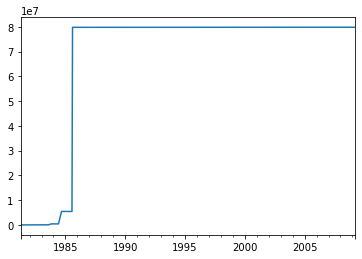

In [136]:
s2.se2.plot()

In [80]:
dd = ss.loc[lde+timedelta(days=1):ldd]
dd

,p,ep,date_start,date_end,Si_1,Pe,Si_2,Ei,Si_3,Et,Sd,se,p_irri,sd2,se2,pi
1985-07-20,2.204839,3.104965,1981-04-01,2009-03-31,2.204839,0.000000,2.204839,2.204839,0.000000,1.484012,-1.484012,0.00000,6.303146,-1.484012,0.00000,6.303146
1985-07-21,0.612375,2.959213,1981-04-01,2009-03-31,0.612375,0.000000,0.612375,0.612375,0.000000,1.414350,-2.898361,0.00000,6.303146,-2.898361,0.00000,6.303146
1985-07-22,1.815957,2.107187,1981-04-01,2009-03-31,1.815957,0.000000,1.815957,1.815957,0.000000,1.007126,-3.905487,0.00000,6.303146,-3.905487,0.00000,6.303146
1985-07-23,3.991122,2.284259,1981-04-01,2009-03-31,3.991122,1.491122,2.500000,2.284259,0.215741,1.091757,-3.506122,0.00000,7.794268,-3.506122,0.00000,6.303146
1985-07-24,0.137374,3.414973,1981-04-01,2009-03-31,0.353114,0.000000,0.353114,0.353114,0.000000,1.632179,-5.138301,0.00000,6.303146,-5.138301,0.00000,6.303146
1985-07-25,0.408678,3.367751,1981-04-01,2009-03-31,0.408678,0.000000,0.408678,0.408678,0.000000,1.609610,-6.747911,0.00000,6.303146,-6.747911,0.00000,6.303146
1985-07-26,0.099673,2.973606,1981-04-01,2009-03-31,0.099673,0.000000,0.099673,0.099673,0.000000,1.421229,-8.169141,0.00000,6.303146,-8.169141,0.00000,6.303146
1985-07-27,0.000000,3.021514,1981-04-01,2009-03-31,0.000000,0.000000,0.000000,0.000000,0.000000,1.444126,-9.613267,0.00000,6.303146,-9.613267,0.00000,6.303146
1985-07-28,1.040999,2.646258,1981-04-01,2009-03-31,1.040999,0.000000,1.040999,1.040999,0.000000,1.264774,-10.878040,0.00000,6.303146,-10.878040,0.00000,6.303146
1985-07-29,0.091530,3.173414,1981-04-01,2009-03-31,0.091530,0.000000,0.091530,0.091530,0.000000,1.516727,-12.394767,0.00000,6.303146,-12.394767,0.00000,6.303146


<AxesSubplot:>

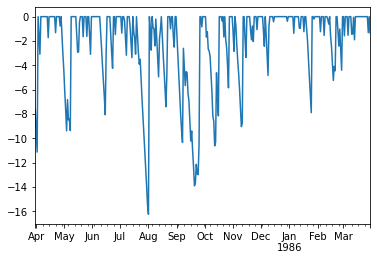

In [81]:
ss.Sd.plot()

<AxesSubplot:>

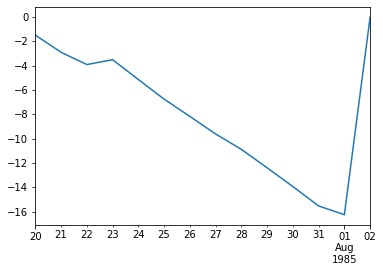

In [82]:
dd.sd2.plot()

In [83]:
s2

,p,ep,date_start,date_end,Si_1,Pe,Si_2,Ei,Si_3,Et,Sd,se,p_irri,sd2,se2,pi
1981-04-01,18.166052,2.923416,1981-04-01,2009-03-31,18.166052,15.666052,2.5,2.5,0.0,1.397241,0.000000,0.000000,15.666052,0.000000,14.268811,0.0
1981-04-02,3.025998,2.843305,1981-04-01,2009-03-31,3.025998,0.525998,2.5,2.5,0.0,1.358952,-0.832954,0.000000,0.525998,-0.832954,0.000000,0.0
1981-04-03,3.149284,2.669151,1981-04-01,2009-03-31,3.149284,0.649284,2.5,2.5,0.0,1.275715,-1.459385,0.000000,0.649284,-1.459385,0.000000,0.0
1981-04-04,9.056500,2.997876,1981-04-01,2009-03-31,9.056500,6.556500,2.5,2.5,0.0,1.432829,0.000000,5.123671,6.556500,0.000000,5.123671,0.0
1981-04-05,27.943600,3.353763,1981-04-01,2009-03-31,27.943600,25.443600,2.5,2.5,0.0,1.602924,0.000000,23.840676,25.443600,0.000000,23.840676,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-03-27,7.036840,3.899651,1981-04-01,2009-03-31,7.036840,4.536840,2.5,2.5,0.0,1.863830,0.000000,2.673009,4.536840,0.000000,2.673009,0.0
2009-03-28,4.433677,3.870490,1981-04-01,2009-03-31,4.433677,1.933677,2.5,2.5,0.0,1.849893,0.000000,0.083784,1.933677,0.000000,0.083784,0.0
2009-03-29,9.714232,3.798144,1981-04-01,2009-03-31,9.714232,7.214232,2.5,2.5,0.0,1.815315,0.000000,5.398916,7.214232,0.000000,5.398916,0.0
2009-03-30,10.625620,3.459156,1981-04-01,2009-03-31,10.625620,8.125620,2.5,2.5,0.0,1.653297,0.000000,6.472323,8.125620,0.000000,6.472323,0.0


In [84]:
df_se

,start_date_se,end_date_se,start_date_irri,end_date_irri,se,f,se_used,iwu_mean,days_irri
0,1981-04-01,1981-10-26,1981-10-06,1981-10-27,686.586136,0.038477,26.417654,48.248655,21
1,1981-10-26,1982-11-20,1982-04-27,1982-12-19,1780.068226,0.038477,68.491372,48.248655,236
2,1982-11-20,1983-09-29,1983-07-27,1983-10-17,2070.290816,0.038477,79.658215,48.248655,82
3,1983-09-29,1984-08-09,1984-06-01,1984-09-01,1927.305253,0.038477,74.156585,48.248655,92
4,1984-08-09,1985-08-01,1985-07-19,1985-08-02,2293.433500,0.038477,88.244037,48.248655,14


In [130]:
sef

,start_date_se,end_date_se,start_date_irri,end_date_irri,se,f,se_used,iwu_mean,days_irri
0,1981-04-01,1981-10-26,1981-10-06,1981-10-27,686.586136,0.038477,26.417654,48.248655,21
1,1981-10-26,1982-11-20,1982-04-27,1982-12-19,1780.068226,0.038477,68.491372,48.248655,236
2,1982-11-20,1983-09-29,1983-07-27,1983-10-17,2070.290816,0.038477,79.658215,48.248655,82
3,1983-09-29,1984-08-09,1984-06-01,1984-09-01,1927.305253,0.038477,74.156585,48.248655,92
4,1984-08-09,1985-08-01,1985-07-19,1985-08-02,2293.433500,0.038477,88.244037,48.248655,14


/tmp/ipykernel_1508403/1515604959.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sd_fopt['pi'] = sd_fopt['p_irri']-sd_fopt['Pe']
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


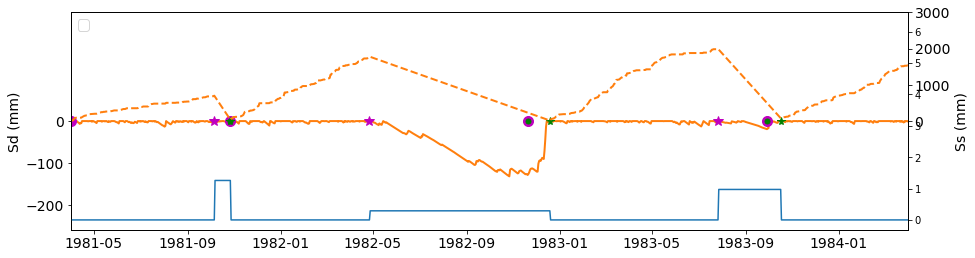

In [131]:
## PLOT TIMESERIES OF SD AND SS AND PI
# sd_ni = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/no_irri/sd/{c}.csv', index_col=0)
# sd_ni.index = pd.to_datetime(sd_ni.index)
# sd_iwu = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu2/sd/{c}_fiwu2.csv', index_col=0)
# sd_iwu.index = pd.to_datetime(sd_iwu.index)
# sd_opt = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sd/{c}_f0.9ia.csv', index_col=0)
# sd_opt.index = pd.to_datetime(sd_opt.index)
# # se_f0 = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/no_irri/se/{catch_id}.csv',index_col=0)
# se_fiwu = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu2/se/{catch_id}_fiwu2.csv',index_col=0)
# se_fopt = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/se/{catch_id}_f0.9ia.csv',index_col=0)
# # se_f0.index = pd.to_datetime(sd_f0.index)
# se_fiwu.index = pd.to_datetime(se_fiwu.index)
# se_fopt.index = pd.to_datetime(se_fopt.index)
sd_fopt = s2

def se_cum(sdf,sef):
    se = sdf.se2
    se_cum=[]
    for i in range(1,len(sef)):
        if(i==1):
            start = sef.start_date_se[i-1]
        else:
            start = sef.end_date_irri[i-2]
        # end = sef.start_date_se[i]
        end = sef.start_date_irri[i-1]
        se0 = se[start:end]
        se0 = se0.cumsum()
        
        se_cum.append(se0)
    se_c = pd.concat(se_cum)
    return se_c

# se_c_f0 = se_cum(sd_f0,se_f0)
# se_c_fopt = se_cum(sd_fopt,se_fopt)
# se_c_fiwu = se_cum(sd_fiwu,se_fiwu)
se_c_fopt = se_cum(sd_fopt,df_se)


fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
ax3 = ax.twinx()
sd_fopt['pi'] = sd_fopt['p_irri']-sd_fopt['Pe']
ax3.plot(sd_fopt.index,sd_fopt.pi)
# ax2.plot(se_c_f0.index,se_c_f0)
# ax2.plot(se_c_fiwu.index,se_c_fiwu,color='tab:blue',linewidth=2,linestyle='--')
ax2.plot(se_c_fopt.index,se_c_fopt,color='tab:orange',linewidth=2,linestyle='--')
# ax.plot(sd_ni.index, sd_ni.Sd,color='k',linewidth=2,label='$S_{\mathrm{r,NI}}$='+str(int(sr_df.loc[c].sr_2_f0))+' mm')
# ax.plot(sd_iwu.index, sd_iwu.sd2,color='tab:blue',linewidth=2, label='$S_{\mathrm{r,IWU}}$='+str(int(sr_df.loc[c].sr_2_fiwu))+' mm')
ax.plot(sd_fopt.index, sd_fopt.sd2,color='tab:orange',linewidth=2)
ax.plot(df_se.start_date_se,np.zeros(len(df_se)),'mo',markersize=10)
ax.plot(df_se.end_date_se,np.zeros(len(df_se)),'go',markersize=5)
ax.plot(df_se.start_date_irri,np.zeros(len(df_se)),'m*',markersize=10)
ax.plot(df_se.end_date_irri,np.zeros(len(df_se)),'g*',markersize=8)
ax.set_ylabel('Sd (mm)')
ax.set_yticks([0,-100,-200])
ax2.set_yticks([0,1000,2000,3000])
ax.set_ylim(-260,0)
ax2.set_ylim(0,3000)
ax.set_ylabel('Sd (mm)', size=14)
ax2.set_ylabel('Ss (mm)', size=14)
ax.tick_params(axis='both', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
align_yaxis(ax, 0, ax2, 0)
adjust_yaxis(ax,0,0)
ax.set_xlim(sd_fopt.index[0],sd_fopt.index[3*365])
ax.legend(ncol=3,fontsize=14,loc='upper left')
# ax.set_title(f'Catchment {c}, IA={np.round(s.loc[c].ia,3)},IA2={np.round(s.loc[c].ia2,3)}, fiwu={np.round(s.loc[c].fiwu,3)}, foptia={np.round(s.loc[c].foptia,3)}')

# fig = plt.figure(figsize=(15,3))
# ax = fig.add_subplot(212)
# sd_fopt['pi'] = sd_fopt['p_irri']-sd_fopt['Pe']
# ax.plot(sd_fopt.index,sd_fopt.pi)
# ax.set_xlim(sd_fopt.index[0],sd_fopt.index[6*365])
# # ax.set_ylim(0,0.5)

In [94]:
se_c_fopt

1981-04-01      14.268811
1981-04-02      14.268811
1981-04-03      14.268811
1981-04-04      19.392483
1981-04-05      43.233158
                 ...     
1984-05-28    1915.530967
1984-05-29    1915.530967
1984-05-30    1917.971341
1984-05-31    1925.999317
1984-06-01    1927.305253
Name: se2, Length: 870, dtype: float64

In [119]:
sdf, sef = sd_fopt,df_se
se = sdf.se2
pi = sdf.pi
se_cum=[]
for i in range(1,len(sef)):
    if(i==1):
        start = sef.start_date_se[i-1]
    else:
        start = sef.end_date_irri[i-2]
    # end = sef.start_date_se[i]
    end = sef.start_date_irri[i-1]
    se0 = se[start:end]
    se0 = se0.cumsum()

    se_cum.append(se0)
    
    start = sef.start_date_irri[i-1]
    end = sef.end_date_irri[i-1]
    se1 = se[start:end]
    d = len(se1)
    
    
    se_cum.append(se0)
se_c = pd.concat(se_cum)

In [132]:
se_cum=[]
i=2
if(i==1):
    start = sef.start_date_se[i-1]
else:
    start = sef.end_date_irri[i-2]
# end = sef.start_date_se[i]
end = sef.start_date_irri[i-1]
se0 = se[start:end]
se0 = se0.cumsum()
se_cum.append(se0)

start = sef.start_date_irri[i-1]
end = sef.end_date_irri[i-1]
se1 = se[start:end]
d = len(se1)
print(d)

se_c = pd.concat(se_cum)

237


In [133]:
se1

1982-04-27    19.309870
1982-04-28     0.000000
1982-04-29     0.000000
1982-04-30     1.913690
1982-05-01     0.000000
                ...    
1982-12-15    29.211258
1982-12-16     0.000000
1982-12-17     0.000000
1982-12-18    47.129229
1982-12-19    15.712305
Freq: D, Name: se2, Length: 237, dtype: float64